# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=20,
        fold=4,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_11-58-43/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5508 | MulticlassF1Score=0.0727
Batch-30 : CrossEntropyLoss=2.4612 | MulticlassF1Score=0.1635
Batch-45 : CrossEntropyLoss=2.4611 | MulticlassF1Score=0.2086
Batch-60 : CrossEntropyLoss=2.4276 | MulticlassF1Score=0.2529
Batch-75 : CrossEntropyLoss=2.3874 | MulticlassF1Score=0.3055
Batch-90 : CrossEntropyLoss=2.3869 | MulticlassF1Score=0.3465
Batch-105: CrossEntropyLoss=2.3921 | MulticlassF1Score=0.3767
Batch-120: CrossEntropyLoss=2.3954 | MulticlassF1Score=0.4003
Batch-135: CrossEntropyLoss=2.3836 | MulticlassF1Score=0.4181
Batch-150: CrossEntropyLoss=2.4128 | MulticlassF1Score=0.4328
Batch-165: CrossEntropyLoss=2.3756 | MulticlassF1Score=0.4465
Batch-180: CrossEntropyLoss=2.3855 | MulticlassF1Score=0.4650
Batch-195: CrossEntropyLoss=2.3494 | MulticlassF1Score=0.4803
Batch-210: CrossEntropyLoss=2.3501 | MulticlassF1Score=0.4947
Batch-225: CrossEntropyLoss=2.3328 | MulticlassF1Score=0.5064
Batch-226: CrossEntropyLoss=2.3388 | MulticlassF1Score=0.5069

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3633 | MulticlassF1Score=0.6781
Batch-30 : CrossEntropyLoss=2.3454 | MulticlassF1Score=0.6807
Batch-45 : CrossEntropyLoss=2.3755 | MulticlassF1Score=0.6786
Batch-60 : CrossEntropyLoss=2.3421 | MulticlassF1Score=0.6745
Batch-63 : CrossEntropyLoss=2.3363 | MulticlassF1Score=0.6753

Training   : Mean CrossEntropyLoss = 2.4104 | Mean MulticlassF1Score = 0.3442
Validation : Mean CrossEntropyLoss = 2.3491 | Mean MulticlassF1Score = 0.6788

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3386 | MulticlassF1Score=0.6716
Batch-30 : CrossEntropyLoss=2.3512 | MulticlassF1Score=0.6736
Batch-45 : CrossEntropyLoss=2.3393 | MulticlassF1Score=0.6739
Batch-60 : CrossEntropyLoss=2.3399 | MulticlassF1Score=0.6820
Batch-75 : CrossEntropyLoss=2.3320 | MulticlassF1Score=0.6927
Batch-90 : CrossEntropyLoss=2.3318 | MulticlassF1Score=0.7004
Batch-105: CrossEntropyLoss=2.3303 | MulticlassF1Score=0.7057
Batch-120: CrossEntropyLoss=2.3279 | MulticlassF1Score=0.7121
Batch-135: CrossEntropyLoss=2.3063 | MulticlassF1Score=0.7200
Batch-150: CrossEntropyLoss=2.3214 | MulticlassF1Score=0.7266
Batch-165: CrossEntropyLoss=2.3123 | MulticlassF1Score=0.7328
Batch-180: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.7375
Batch-195: CrossEntropyLoss=2.3066 | MulticlassF1Score=0.7410
Batch-210: CrossEntropyLoss=2.3251 | MulticlassF1Score=0.7441
Batch-225: CrossEntropyLoss=2.3063 | MulticlassF1Score=0.7472
Batch-226: CrossEntropyLoss=2.3299 | MulticlassF1Score=0.7472

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3155 | MulticlassF1Score=0.7874
Batch-30 : CrossEntropyLoss=2.3108 | MulticlassF1Score=0.7877
Batch-45 : CrossEntropyLoss=2.3093 | MulticlassF1Score=0.7900
Batch-60 : CrossEntropyLoss=2.3171 | MulticlassF1Score=0.7896
Batch-63 : CrossEntropyLoss=2.3209 | MulticlassF1Score=0.7897

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3270 | Mean MulticlassF1Score = 0.7086
Validation : Mean CrossEntropyLoss = 2.3139 | Mean MulticlassF1Score = 0.7894

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3145 | MulticlassF1Score=0.7924
Batch-30 : CrossEntropyLoss=2.3101 | MulticlassF1Score=0.7900
Batch-45 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.7934
Batch-60 : CrossEntropyLoss=2.3185 | MulticlassF1Score=0.7924
Batch-75 : CrossEntropyLoss=2.3071 | MulticlassF1Score=0.7937
Batch-90 : CrossEntropyLoss=2.3174 | MulticlassF1Score=0.7933
Batch-105: CrossEntropyLoss=2.3120 | MulticlassF1Score=0.7940
Batch-120: CrossEntropyLoss=2.3158 | MulticlassF1Score=0.7940
Batch-135: CrossEntropyLoss=2.3130 | MulticlassF1Score=0.7946
Batch-150: CrossEntropyLoss=2.3121 | MulticlassF1Score=0.7933
Batch-165: CrossEntropyLoss=2.3214 | MulticlassF1Score=0.7931
Batch-180: CrossEntropyLoss=2.3127 | MulticlassF1Score=0.7930
Batch-195: CrossEntropyLoss=2.3063 | MulticlassF1Score=0.7929
Batch-210: CrossEntropyLoss=2.3125 | MulticlassF1Score=0.7930
Batch-225: CrossEntropyLoss=2.3150 | MulticlassF1Score=0.7928
Batch-226: CrossEntropyLoss=2.3074 | MulticlassF1Score=0.7929

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3107 | MulticlassF1Score=0.7975
Batch-30 : CrossEntropyLoss=2.3103 | MulticlassF1Score=0.7958
Batch-45 : CrossEntropyLoss=2.3158 | MulticlassF1Score=0.7931
Batch-60 : CrossEntropyLoss=2.3130 | MulticlassF1Score=0.7925
Batch-63 : CrossEntropyLoss=2.3063 | MulticlassF1Score=0.7925

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3122 | Mean MulticlassF1Score = 0.7928
Validation : Mean CrossEntropyLoss = 2.3124 | Mean MulticlassF1Score = 0.7955

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3074 | MulticlassF1Score=0.7948
Batch-30 : CrossEntropyLoss=2.3221 | MulticlassF1Score=0.7970
Batch-45 : CrossEntropyLoss=2.3132 | MulticlassF1Score=0.7955
Batch-60 : CrossEntropyLoss=2.3072 | MulticlassF1Score=0.7962
Batch-75 : CrossEntropyLoss=2.3122 | MulticlassF1Score=0.7949
Batch-90 : CrossEntropyLoss=2.3095 | MulticlassF1Score=0.7947
Batch-105: CrossEntropyLoss=2.3027 | MulticlassF1Score=0.7957
Batch-120: CrossEntropyLoss=2.3042 | MulticlassF1Score=0.7961
Batch-135: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.7977
Batch-150: CrossEntropyLoss=2.3097 | MulticlassF1Score=0.7982
Batch-165: CrossEntropyLoss=2.3180 | MulticlassF1Score=0.7993
Batch-180: CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8001
Batch-195: CrossEntropyLoss=2.3099 | MulticlassF1Score=0.8007
Batch-210: CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8012
Batch-225: CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8020
Batch-226: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8021

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8253
Batch-30 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8230
Batch-45 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8216
Batch-60 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8228
Batch-63 : CrossEntropyLoss=2.3089 | MulticlassF1Score=0.8229

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3091 | Mean MulticlassF1Score = 0.7976
Validation : Mean CrossEntropyLoss = 2.3038 | Mean MulticlassF1Score = 0.8232

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8309
Batch-30 : CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8323
Batch-45 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8317
Batch-60 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8302
Batch-75 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8293
Batch-90 : CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8293
Batch-105: CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8291
Batch-120: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8299
Batch-135: CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8302
Batch-150: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8303
Batch-165: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8297
Batch-180: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8295
Batch-195: CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8291
Batch-210: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8293
Batch-225: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8288
Batch-226: CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8288

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8314
Batch-30 : CrossEntropyLoss=2.3103 | MulticlassF1Score=0.8300
Batch-45 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8278
Batch-60 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8265
Batch-63 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8266

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3008 | Mean MulticlassF1Score = 0.8301
Validation : Mean CrossEntropyLoss = 2.3015 | Mean MulticlassF1Score = 0.8291

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8325
Batch-30 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8311
Batch-45 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8306
Batch-60 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8301
Batch-75 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8307
Batch-90 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8316
Batch-105: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8313
Batch-120: CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8309
Batch-135: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8310
Batch-150: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8317
Batch-165: CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8321
Batch-180: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8321
Batch-195: CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8314
Batch-210: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8316
Batch-225: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8314
Batch-226: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8315

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8267
Batch-30 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8285
Batch-45 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8271
Batch-60 : CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8272
Batch-63 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8277

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2997 | Mean MulticlassF1Score = 0.8315
Validation : Mean CrossEntropyLoss = 2.3011 | Mean MulticlassF1Score = 0.8291

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8362
Batch-30 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8336
Batch-45 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8347
Batch-60 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8346
Batch-75 : CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8341
Batch-90 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8337
Batch-105: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8336
Batch-120: CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8335
Batch-135: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8331
Batch-150: CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8335
Batch-165: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8334
Batch-180: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8333
Batch-195: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8331
Batch-210: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8330
Batch-225: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8332
Batch-226: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8332

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8253
Batch-30 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8260
Batch-45 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8277
Batch-60 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8279
Batch-63 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8280

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2993 | Mean MulticlassF1Score = 0.8339
Validation : Mean CrossEntropyLoss = 2.3010 | Mean MulticlassF1Score = 0.8272

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8255
Batch-30 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8314
Batch-45 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8322
Batch-60 : CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8331
Batch-75 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8336
Batch-90 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8343
Batch-105: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8347
Batch-120: CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8346
Batch-135: CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8348
Batch-150: CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8347
Batch-165: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8349
Batch-180: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8348
Batch-195: CrossEntropyLoss=2.3162 | MulticlassF1Score=0.8348
Batch-210: CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8349
Batch-225: CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8349
Batch-226: CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8350

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8272
Batch-30 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8286
Batch-45 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8295
Batch-60 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8289
Batch-63 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8290

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2986 | Mean MulticlassF1Score = 0.8337
Validation : Mean CrossEntropyLoss = 2.3006 | Mean MulticlassF1Score = 0.8284

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8419
Batch-30 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8390
Batch-45 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8362
Batch-60 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8362
Batch-75 : CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8371
Batch-90 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8368
Batch-105: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8404
Batch-120: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8436
Batch-135: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8452
Batch-150: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8470
Batch-165: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8483
Batch-180: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8491
Batch-195: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8503
Batch-210: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8509
Batch-225: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8517
Batch-226: CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8516

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8612
Batch-30 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8581
Batch-45 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8614
Batch-60 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8629
Batch-63 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8625

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2937 | Mean MulticlassF1Score = 0.8431
Validation : Mean CrossEntropyLoss = 2.2906 | Mean MulticlassF1Score = 0.8627

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8825
Batch-30 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8811
Batch-45 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8805
Batch-60 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8802
Batch-75 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8794
Batch-90 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8794
Batch-105: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8793
Batch-120: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8801
Batch-135: CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8800
Batch-150: CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8801
Batch-165: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8801
Batch-180: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8798
Batch-195: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8798
Batch-210: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8799
Batch-225: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8800
Batch-226: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8800

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8742
Batch-30 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8744
Batch-45 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8750
Batch-60 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8741
Batch-63 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8742

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2852 | Mean MulticlassF1Score = 0.8800
Validation : Mean CrossEntropyLoss = 2.2871 | Mean MulticlassF1Score = 0.8748

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8897
Batch-30 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8864
Batch-45 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8835
Batch-60 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8833
Batch-75 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8830
Batch-90 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8828
Batch-105: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8832
Batch-120: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8836
Batch-135: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8838
Batch-150: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8842
Batch-165: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8843
Batch-180: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8841
Batch-195: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8840
Batch-210: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8837
Batch-225: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8834
Batch-226: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8834

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8714
Batch-30 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8737
Batch-45 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8756
Batch-60 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8744
Batch-63 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8750

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2839 | Mean MulticlassF1Score = 0.8844
Validation : Mean CrossEntropyLoss = 2.2866 | Mean MulticlassF1Score = 0.8740

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8841
Batch-30 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8879
Batch-45 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8882
Batch-60 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8881
Batch-75 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8876
Batch-90 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8864
Batch-105: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8868
Batch-120: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8869
Batch-135: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8869
Batch-150: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8868
Batch-165: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8864
Batch-180: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8862
Batch-195: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8860
Batch-210: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8859
Batch-225: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8860
Batch-226: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8860

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8755
Batch-30 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8725
Batch-45 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8735
Batch-60 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8763
Batch-63 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8763

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2831 | Mean MulticlassF1Score = 0.8868
Validation : Mean CrossEntropyLoss = 2.2862 | Mean MulticlassF1Score = 0.8754

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8883
Batch-30 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8867
Batch-45 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8873
Batch-60 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8882
Batch-75 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8881
Batch-90 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8878
Batch-105: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8872
Batch-120: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8873
Batch-135: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8872
Batch-150: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8871
Batch-165: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8870
Batch-180: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8873
Batch-195: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8880
Batch-210: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8886
Batch-225: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8890
Batch-226: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8891

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8869
Batch-30 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8846
Batch-45 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8859
Batch-60 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8854
Batch-63 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8852

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2820 | Mean MulticlassF1Score = 0.8875
Validation : Mean CrossEntropyLoss = 2.2834 | Mean MulticlassF1Score = 0.8854

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8951
Batch-30 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8954
Batch-45 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8958
Batch-60 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8950
Batch-75 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.8966
Batch-90 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8960
Batch-105: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8962
Batch-120: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8963
Batch-135: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8960
Batch-150: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8963
Batch-165: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8964
Batch-180: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8968
Batch-195: CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8966
Batch-210: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8971
Batch-225: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8970
Batch-226: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8970

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8881
Batch-30 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8887
Batch-45 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8874
Batch-60 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8864
Batch-63 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8861

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2795 | Mean MulticlassF1Score = 0.8963
Validation : Mean CrossEntropyLoss = 2.2830 | Mean MulticlassF1Score = 0.8867

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8976
Batch-30 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8986
Batch-45 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.8986
Batch-60 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8992
Batch-75 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8996
Batch-90 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8990
Batch-105: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8989
Batch-120: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8988
Batch-135: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8991
Batch-150: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8988
Batch-165: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9002
Batch-180: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9023
Batch-195: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9037
Batch-210: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9048
Batch-225: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9059
Batch-226: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9059

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9164
Batch-30 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9153
Batch-45 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.9124
Batch-60 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9120
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9122

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2768 | Mean MulticlassF1Score = 0.9005
Validation : Mean CrossEntropyLoss = 2.2752 | Mean MulticlassF1Score = 0.9142

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9287
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9283
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9280
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9283
Batch-75 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9286
Batch-90 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9284
Batch-105: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9287
Batch-120: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9296
Batch-135: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9292
Batch-150: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9292
Batch-165: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9291
Batch-180: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9289
Batch-195: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9290
Batch-210: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9288
Batch-225: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9291
Batch-226: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9292

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9197
Batch-30 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9191
Batch-45 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.9171
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9174
Batch-63 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9174

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9285
Validation : Mean CrossEntropyLoss = 2.2735 | Mean MulticlassF1Score = 0.9195

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9320
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9332
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9330
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9332
Batch-75 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9328
Batch-90 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9332
Batch-105: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9333
Batch-120: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9329
Batch-135: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9331
Batch-150: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9335
Batch-165: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9334
Batch-180: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9332
Batch-195: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9331
Batch-210: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9328
Batch-225: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9326
Batch-226: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9326

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9176
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9195
Batch-45 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9198
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9201
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9201

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2686 | Mean MulticlassF1Score = 0.9331
Validation : Mean CrossEntropyLoss = 2.2725 | Mean MulticlassF1Score = 0.9197

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9348
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9332
Batch-45 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9330
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9341
Batch-75 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9343
Batch-90 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9341
Batch-105: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9342
Batch-120: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9343
Batch-135: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9347
Batch-150: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9351
Batch-165: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9354
Batch-180: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9355
Batch-195: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9354
Batch-210: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9354
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9356
Batch-226: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9356

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9186
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9215
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9208
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9218
Batch-63 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9215

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2676 | Mean MulticlassF1Score = 0.9345
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9203

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9370
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9366
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9356
Batch-60 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9364
Batch-75 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9357
Batch-90 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9360
Batch-105: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9365
Batch-120: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9367
Batch-135: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9369
Batch-150: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9368
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9367
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9370
Batch-195: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9371
Batch-210: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9370
Batch-225: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9369
Batch-226: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9369

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9235
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9228
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9229
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9229
Batch-63 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9224

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9366
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9226

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9405
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9405
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9398
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9393
Batch-75 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9390
Batch-90 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9384
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9385
Batch-120: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9383
Batch-135: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9383
Batch-150: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9380
Batch-165: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9380
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9380
Batch-195: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9382
Batch-210: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9379
Batch-225: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9378
Batch-226: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9378

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9221
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9205
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9216
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9218
Batch-63 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9215

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9390
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9210

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9344
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9358
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9377
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9388
Batch-75 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9385
Batch-90 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9390
Batch-105: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9390
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9389
Batch-135: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9390
Batch-150: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9387
Batch-165: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9385
Batch-180: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9385
Batch-195: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9385
Batch-210: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9387
Batch-225: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9385
Batch-226: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9385

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9177
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9232
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9214
Batch-60 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9222
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9225

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9381
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9207

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9405
Batch-45 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9399
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9401
Batch-75 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9399
Batch-90 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9394
Batch-105: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9396
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9395
Batch-135: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9398
Batch-150: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9390
Batch-165: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9391
Batch-180: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9393
Batch-195: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9393
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9392
Batch-225: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9394
Batch-226: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9394

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9240
Batch-30 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9238
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9234
Batch-60 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9225
Batch-63 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9224

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9403
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9230

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9379
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9389
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9380
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9396
Batch-75 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9397
Batch-90 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9395
Batch-105: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9398
Batch-120: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9402
Batch-135: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9404
Batch-150: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9400
Batch-165: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9395
Batch-180: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9396
Batch-195: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9397
Batch-210: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9396
Batch-225: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9399
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9398

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9236
Batch-30 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9221
Batch-45 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9231
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9232
Batch-63 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9228

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9397
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9229

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9360
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9382
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9402
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9402
Batch-75 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9401
Batch-90 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9405
Batch-105: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9409
Batch-120: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9412
Batch-135: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9412
Batch-150: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9412
Batch-165: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9410
Batch-180: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9409
Batch-195: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9408
Batch-210: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9407
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9408
Batch-226: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9408

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9248
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9251
Batch-45 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9251
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9249
Batch-63 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9251

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9404
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9248

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9434
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9430
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9430
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9427
Batch-75 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9426
Batch-90 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9428
Batch-105: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9421
Batch-120: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9422
Batch-135: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9422
Batch-150: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9424
Batch-165: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9421
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9421
Batch-195: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9420
Batch-210: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9422
Batch-225: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9421
Batch-226: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9422

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9240
Batch-30 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9253
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9252
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9254
Batch-63 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9252

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9424
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9258

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9435
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9427
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9425
Batch-75 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9426
Batch-90 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9426
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9426
Batch-120: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9424
Batch-135: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9424
Batch-150: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9429
Batch-165: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9424
Batch-180: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9427
Batch-195: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9428
Batch-210: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9430
Batch-225: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9430
Batch-226: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9430

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9284
Batch-30 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9267
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9264
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9256
Batch-63 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9256

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9426
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9277

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9474
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9451
Batch-45 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9448
Batch-75 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9447
Batch-90 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9448
Batch-105: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9448
Batch-120: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9448
Batch-135: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9447
Batch-150: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9443
Batch-165: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9442
Batch-180: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9439
Batch-195: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9440
Batch-210: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9443
Batch-225: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9440
Batch-226: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9439

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9285
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9262
Batch-45 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9267
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9271
Batch-63 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9272

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9448
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9273

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9461
Batch-30 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9460
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9458
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9458
Batch-75 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9448
Batch-90 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9441
Batch-105: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9437
Batch-120: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9441
Batch-135: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9445
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9445
Batch-165: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9446
Batch-180: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9444
Batch-195: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9444
Batch-210: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9443
Batch-225: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9443
Batch-226: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9443

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9266
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9263
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9266
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9266
Batch-63 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9268

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9447
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9275

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9462
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9453
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9456
Batch-75 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9453
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9452
Batch-105: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9452
Batch-120: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9454
Batch-135: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9454
Batch-150: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9453
Batch-165: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9451
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9450
Batch-195: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9450
Batch-210: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9450
Batch-225: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9448
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9448

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9229
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9237
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9256
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9264
Batch-63 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9264

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9455
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9243

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9458
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9463
Batch-75 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9462
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9460
Batch-105: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9458
Batch-120: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9464
Batch-135: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9461
Batch-150: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9460
Batch-165: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9459
Batch-180: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9458
Batch-195: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9455
Batch-210: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9455
Batch-225: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9453
Batch-226: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9453

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9270
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9254
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9262
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9270
Batch-63 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9271

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9460
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9266

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9457
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9446
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9451
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9444
Batch-75 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9453
Batch-90 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9461
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9463
Batch-120: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9469
Batch-135: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9471
Batch-150: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9469
Batch-165: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9469
Batch-180: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9470
Batch-195: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9470
Batch-210: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9469
Batch-225: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9469
Batch-226: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9469

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9326
Batch-30 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9304
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9288
Batch-60 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9281
Batch-63 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9279

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9461
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9297

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9426
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9460
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9461
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9457
Batch-75 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9462
Batch-90 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9463
Batch-105: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9464
Batch-120: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9466
Batch-135: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9468
Batch-150: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9469
Batch-165: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9468
Batch-180: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9469
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9479
Batch-210: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9492
Batch-225: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9502
Batch-226: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9502

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9496
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9486
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9472
Batch-63 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9474

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2629 | Mean MulticlassF1Score = 0.9466
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9480

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9667
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9665
Batch-45 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9672
Batch-60 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9678
Batch-75 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9674
Batch-90 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9678
Batch-105: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9675
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9676
Batch-135: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9673
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9672
Batch-165: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9672
Batch-180: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9674
Batch-195: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9672
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9672
Batch-225: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9671
Batch-226: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9671

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9447
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9477
Batch-63 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9670
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9468

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9682
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9696
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9692
Batch-60 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9690
Batch-75 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9690
Batch-90 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9694
Batch-105: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9693
Batch-120: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9691
Batch-135: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9685
Batch-150: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9680
Batch-165: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9680
Batch-180: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9680
Batch-195: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9681
Batch-210: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9680
Batch-225: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9680
Batch-226: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9679

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9482
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9686
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9466

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9710
Batch-30 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9687
Batch-45 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9689
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9685
Batch-75 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9685
Batch-90 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9687
Batch-105: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9689
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9692
Batch-135: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9691
Batch-150: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9691
Batch-165: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9688
Batch-195: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9687
Batch-210: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9687
Batch-225: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9687
Batch-226: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9687

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9467
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9492
Batch-63 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9489

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9691
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9469

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9682
Batch-30 : CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9692
Batch-45 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9698
Batch-60 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9684
Batch-75 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9684
Batch-90 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9686
Batch-105: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9689
Batch-120: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9692
Batch-135: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9692
Batch-150: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9689
Batch-165: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9689
Batch-180: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9687
Batch-195: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9689
Batch-210: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9689
Batch-226: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9690

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9453
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9482
Batch-63 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9486

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9472

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2508 | MulticlassF1Score=0.9721
Batch-30 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9693
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9687
Batch-60 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9689
Batch-75 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9688
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9687
Batch-105: CrossEntropyLoss=2.2522 | MulticlassF1Score=0.9688
Batch-120: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9688
Batch-135: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9692
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9693
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9694
Batch-180: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9694
Batch-195: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9695
Batch-210: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9694
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9692
Batch-226: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9692

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9448
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9484
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9482
Batch-63 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9480

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9694
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9475

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9715
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9706
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9696
Batch-60 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9699
Batch-75 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9698
Batch-90 : CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9702
Batch-105: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9697
Batch-120: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9698
Batch-135: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9695
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9694
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9694
Batch-180: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9692
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9693
Batch-225: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9692
Batch-226: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9692

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9514
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9491
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9486

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9697
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9496
Patience = 1/50❗

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9680
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9678
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9687
Batch-60 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2522 | MulticlassF1Score=0.9681
Batch-90 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9684
Batch-105: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9690
Batch-135: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9692
Batch-150: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9690
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9692
Batch-210: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9692
Batch-225: CrossEntropyLoss=2.2512 | MulticlassF1Score=0.9693
Batch-226: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9693

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9483
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9460
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9686
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9476

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9708
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9714
Batch-45 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9711
Batch-60 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9709
Batch-75 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9708
Batch-90 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9700
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9703
Batch-120: CrossEntropyLoss=2.2512 | MulticlassF1Score=0.9704
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9702
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9701
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9701
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9701
Batch-195: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9700
Batch-210: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9697
Batch-225: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9697
Batch-226: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9697

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9482
Batch-63 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9483

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9706
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9467

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9702
Batch-30 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9711
Batch-45 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9716
Batch-60 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9707
Batch-75 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9711
Batch-90 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9707
Batch-105: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9706
Batch-120: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9706
Batch-135: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9705
Batch-150: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9703
Batch-165: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9700
Batch-180: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9698
Batch-195: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9697
Batch-210: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9694
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9695
Batch-226: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9695

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9473
Batch-63 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9477

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9706
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9479
Patience = 2/50❗

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9680
Batch-30 : CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9705
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9705
Batch-60 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9700
Batch-75 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9693
Batch-90 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9693
Batch-120: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9695
Batch-135: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9695
Batch-150: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9694
Batch-165: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9693
Batch-180: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9693
Batch-195: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9694
Batch-210: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9696
Batch-225: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9695
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9695

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9483

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9694
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9480
Patience = 3/50❗

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9709
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9703
Batch-45 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9704
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9698
Batch-75 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9705
Batch-90 : CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9710
Batch-105: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9706
Batch-120: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9703
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9702
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9703
Batch-165: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9702
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9702
Batch-195: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9702
Batch-210: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9699
Batch-225: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9699
Batch-226: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9699

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9524
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9503
Batch-45 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9500
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9483

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9704
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9507

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9742
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9737
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9735
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9728
Batch-75 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9717
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9716
Batch-105: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9715
Batch-120: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9713
Batch-135: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9713
Batch-150: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9709
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9708
Batch-180: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9708
Batch-195: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9709
Batch-210: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9708
Batch-225: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9707
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9707

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9485

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2565 | Mean MulticlassF1Score = 0.9718
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9464

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9699
Batch-30 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9711
Batch-45 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9715
Batch-60 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9715
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9716
Batch-90 : CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9715
Batch-105: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9716
Batch-120: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9715
Batch-135: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9713
Batch-150: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9713
Batch-165: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9712
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9708
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9709
Batch-210: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9710
Batch-225: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9709
Batch-226: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9709

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9487
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9488
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9492
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9488

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9711
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9488

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9733
Batch-30 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9724
Batch-45 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9713
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9712
Batch-75 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9715
Batch-90 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9712
Batch-105: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9714
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9715
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9716
Batch-150: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9715
Batch-165: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9715
Batch-180: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9713
Batch-195: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9714
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9711
Batch-225: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9711
Batch-226: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9711

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9489
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9483

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9715
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9476

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9711
Batch-30 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9720
Batch-45 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9720
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9715
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9707
Batch-90 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9709
Batch-105: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9710
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9715
Batch-135: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9714
Batch-150: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9714
Batch-165: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9716
Batch-180: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9714
Batch-195: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9713
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9714
Batch-225: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9713
Batch-226: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9713

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9517
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9482
Batch-60 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9490

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9713
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9496

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9731
Batch-30 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9716
Batch-45 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9723
Batch-60 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9719
Batch-75 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9717
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9717
Batch-105: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9715
Batch-120: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9717
Batch-135: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9715
Batch-150: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9716
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9715
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9715
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9715
Batch-210: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9714
Batch-225: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9714
Batch-226: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9714

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9490
Batch-63 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9489

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9717
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9479

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9705
Batch-30 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9696
Batch-45 : CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9705
Batch-60 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9707
Batch-75 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9709
Batch-90 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9713
Batch-105: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9709
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9709
Batch-135: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9708
Batch-150: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9706
Batch-165: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9705
Batch-180: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9705
Batch-195: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9705
Batch-210: CrossEntropyLoss=2.2520 | MulticlassF1Score=0.9705
Batch-225: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9706
Batch-226: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9707

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9498
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9493
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9498
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9494
Batch-63 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9494

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2565 | Mean MulticlassF1Score = 0.9706
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9499
Patience = 4/50❗

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9731
Batch-30 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9720
Batch-45 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9716
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9727
Batch-75 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9725
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9721
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9722
Batch-120: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9719
Batch-135: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9721
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9720
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9716
Batch-180: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9715
Batch-195: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9712
Batch-210: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9712
Batch-225: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9713
Batch-226: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9713

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9516
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9526
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9508
Batch-60 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9501
Batch-63 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9498

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9718
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9509

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2563
Best CrossEntropyLoss training    : 2.2631
Best MulticlassF1Score validation : 0.9718
Best MulticlassF1Score validation : 0.9509
Training duration                 : 2.0126 minutes.
Training date                     : 2022-10-19 14:38:58.650507+08:00


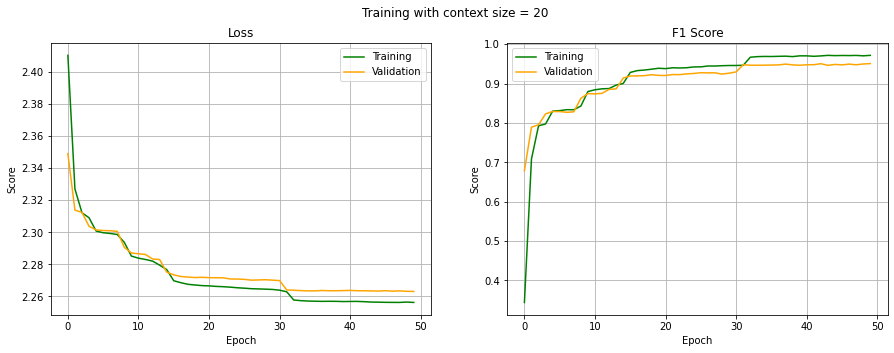

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9722, device='cuda:0'),
 tensor(0.9498, device='cuda:0'),
 tensor(0.9495, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9722, device='cuda:0'),
 tensor(0.9498, device='cuda:0'),
 tensor(0.9495, device='cuda:0'))

## Heatmap

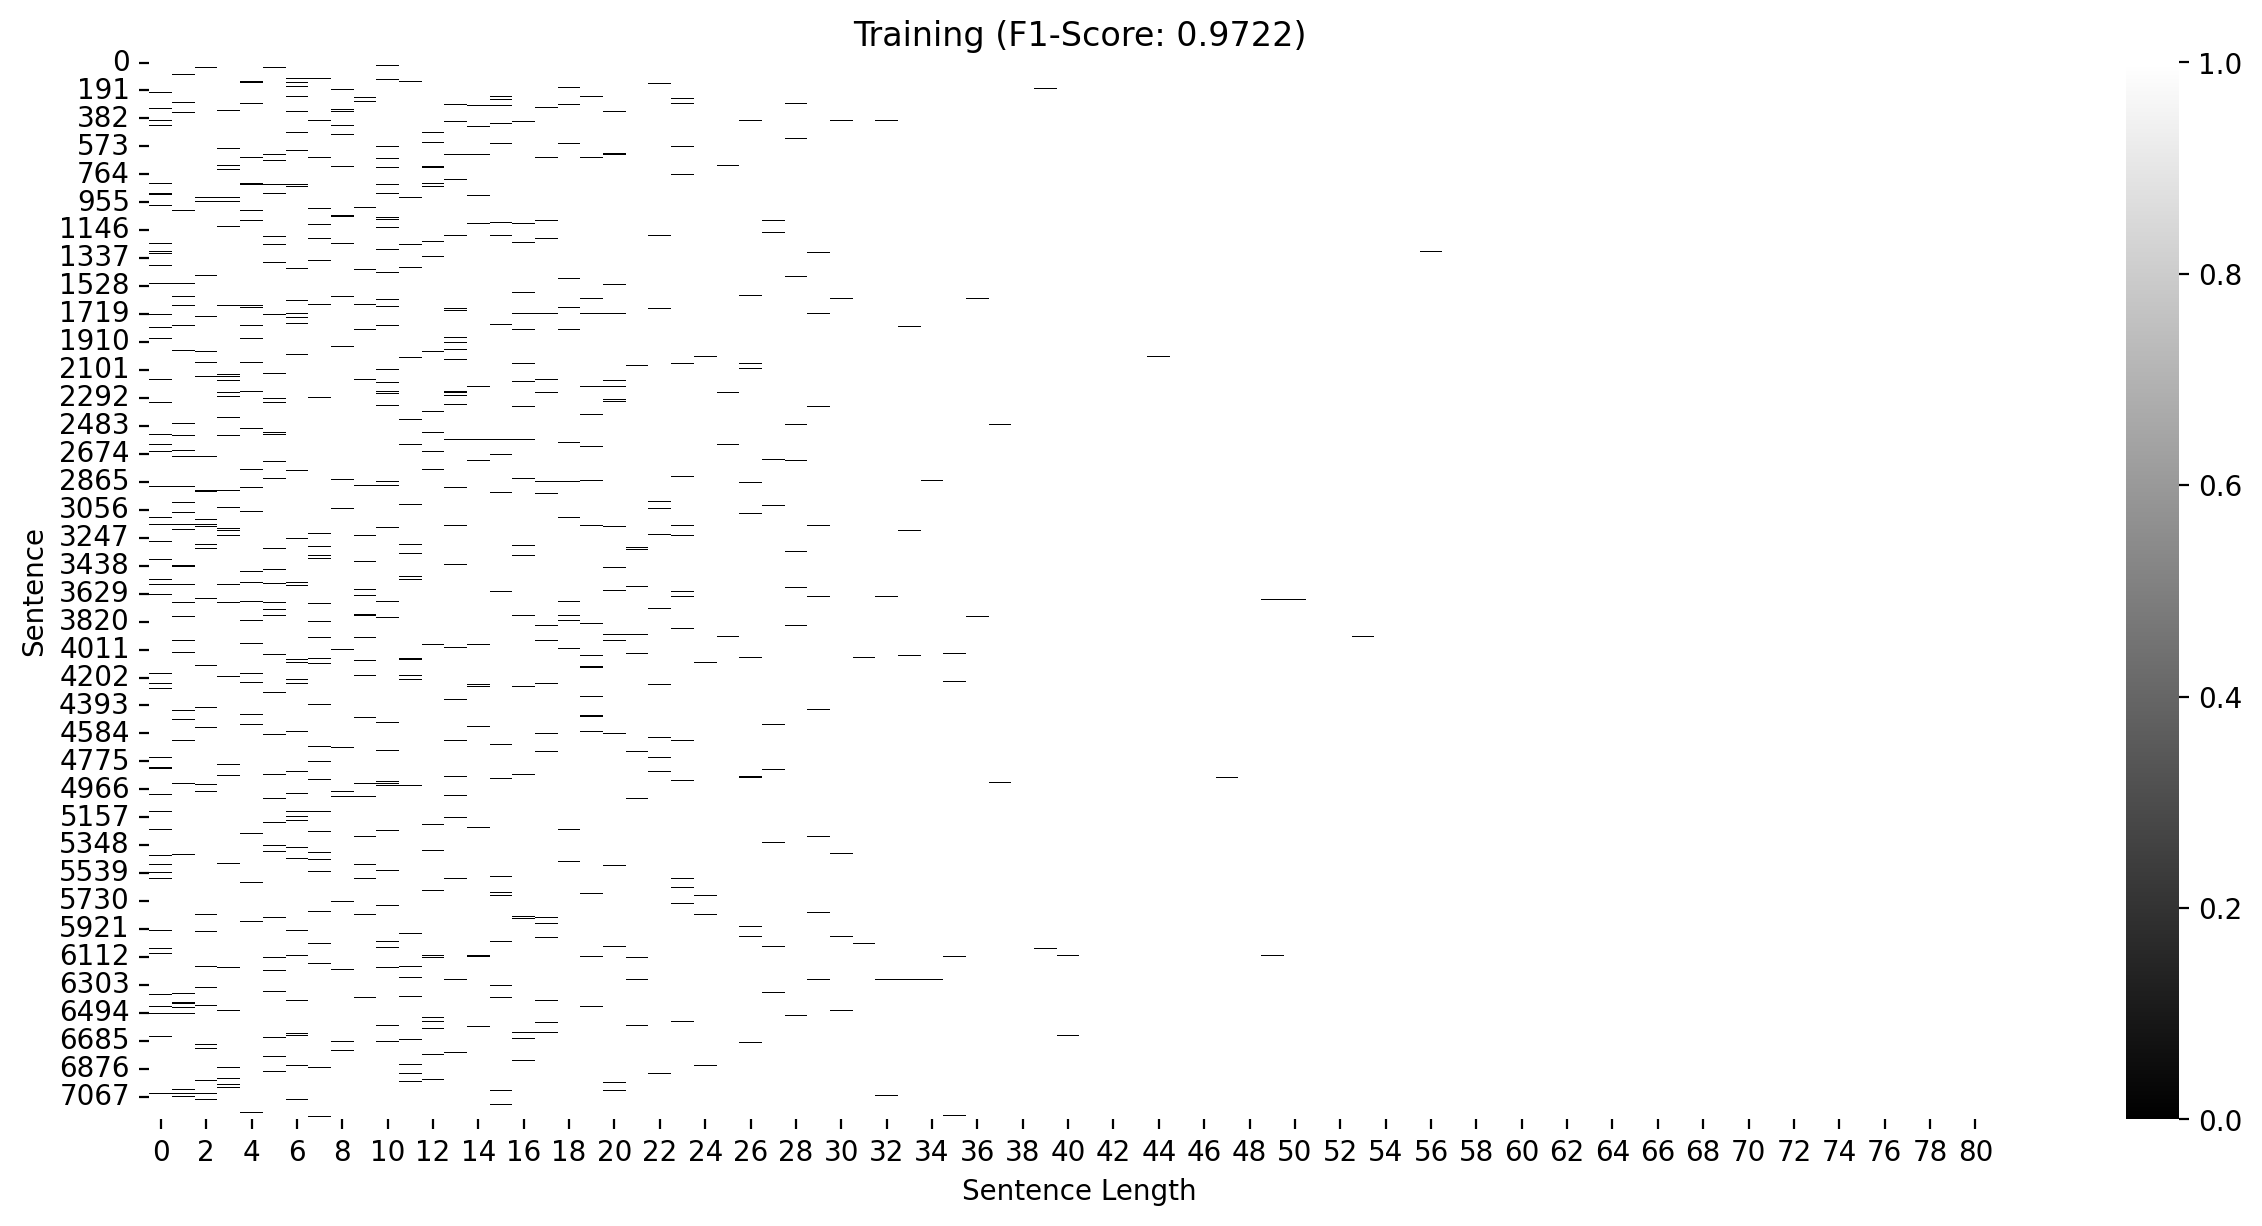

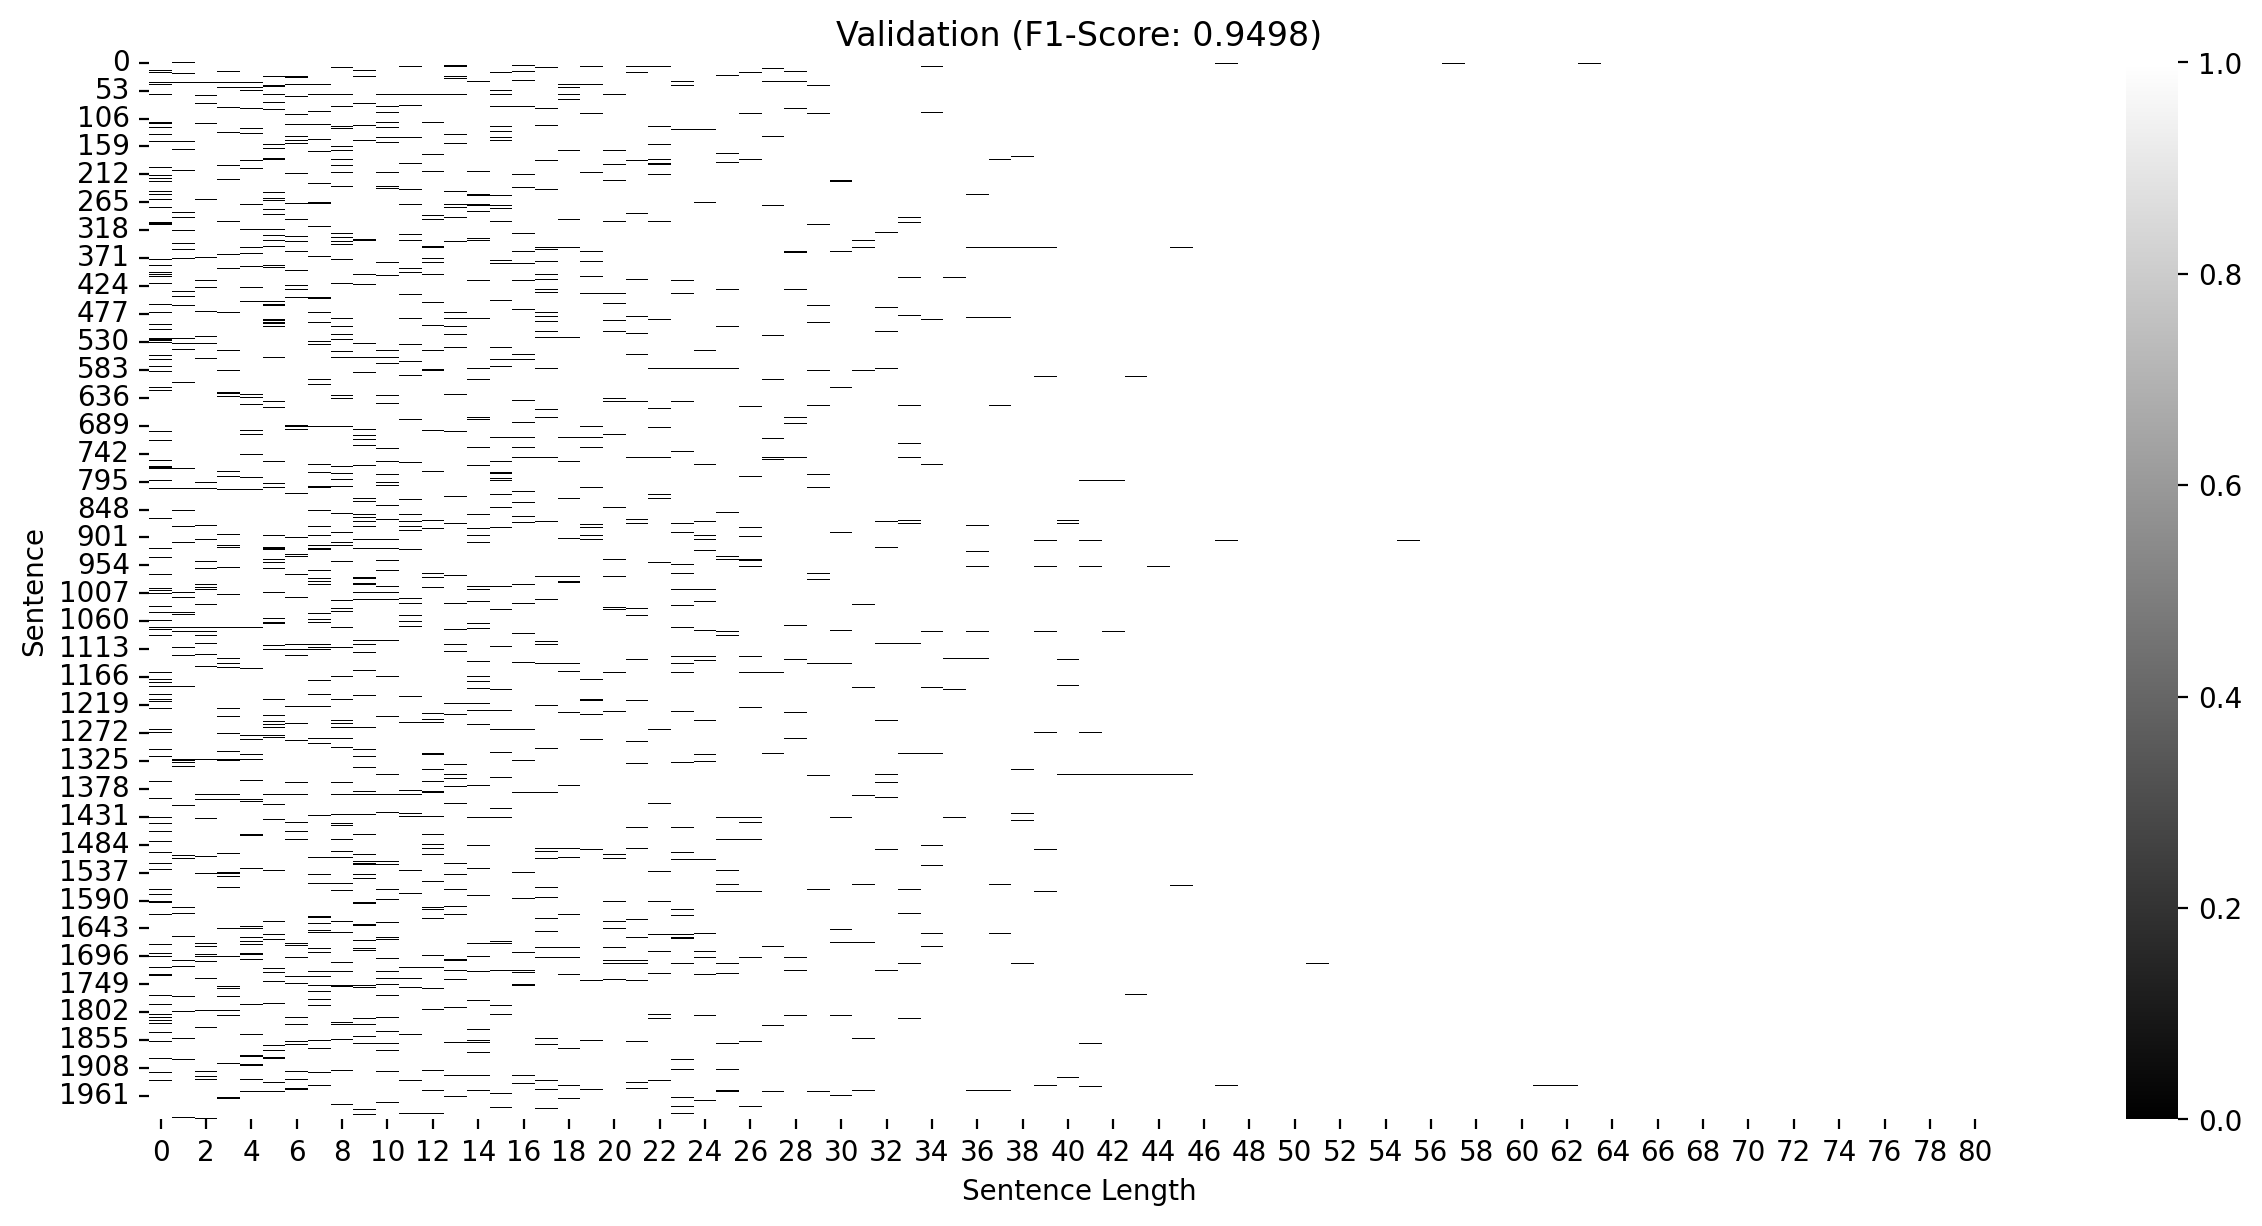

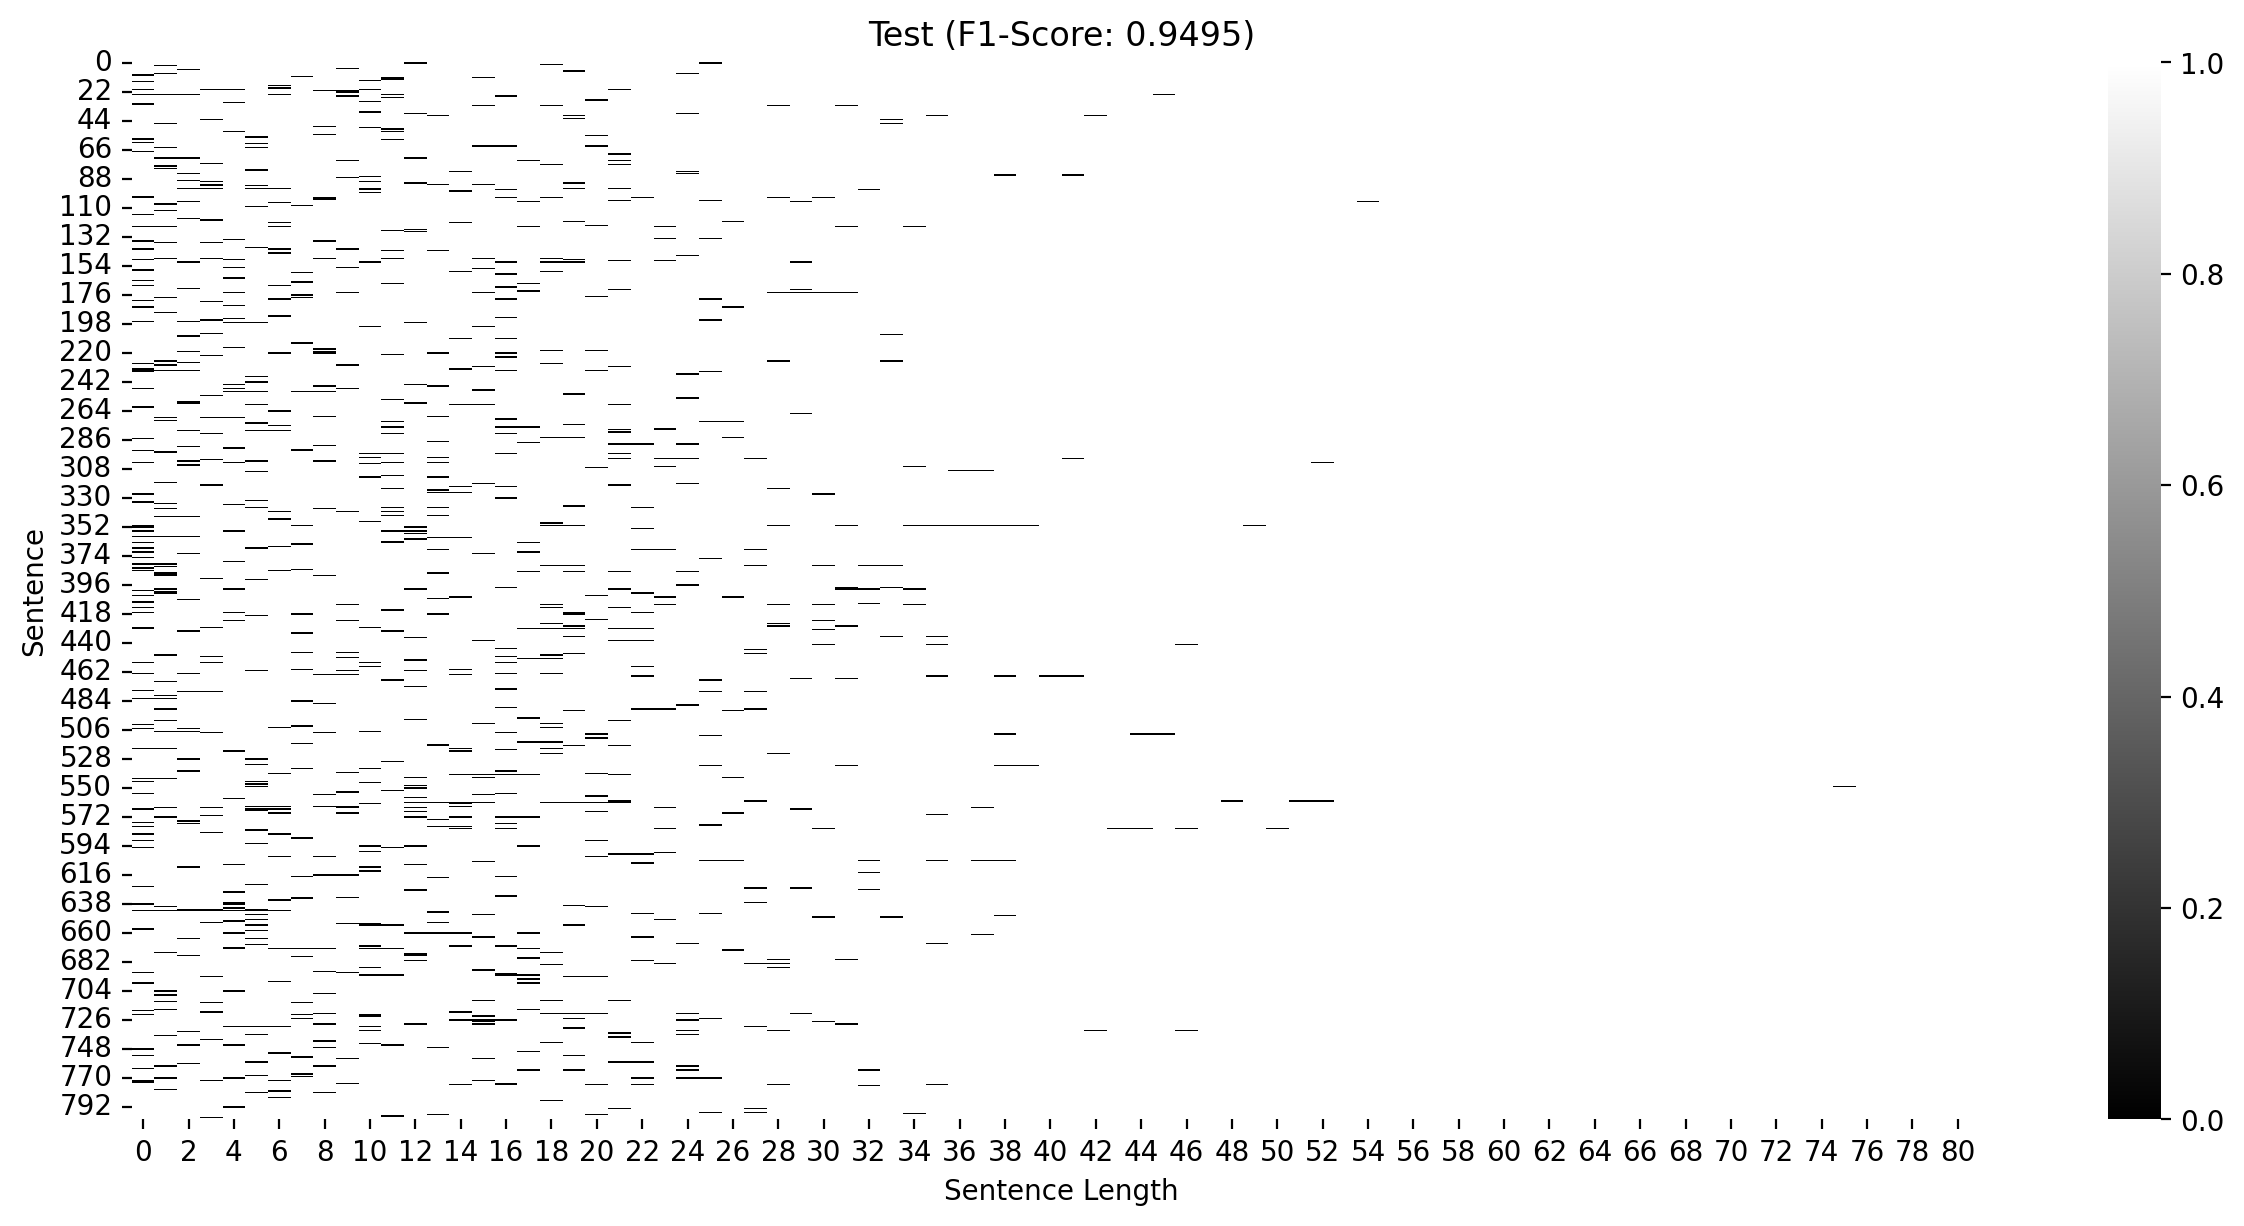

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


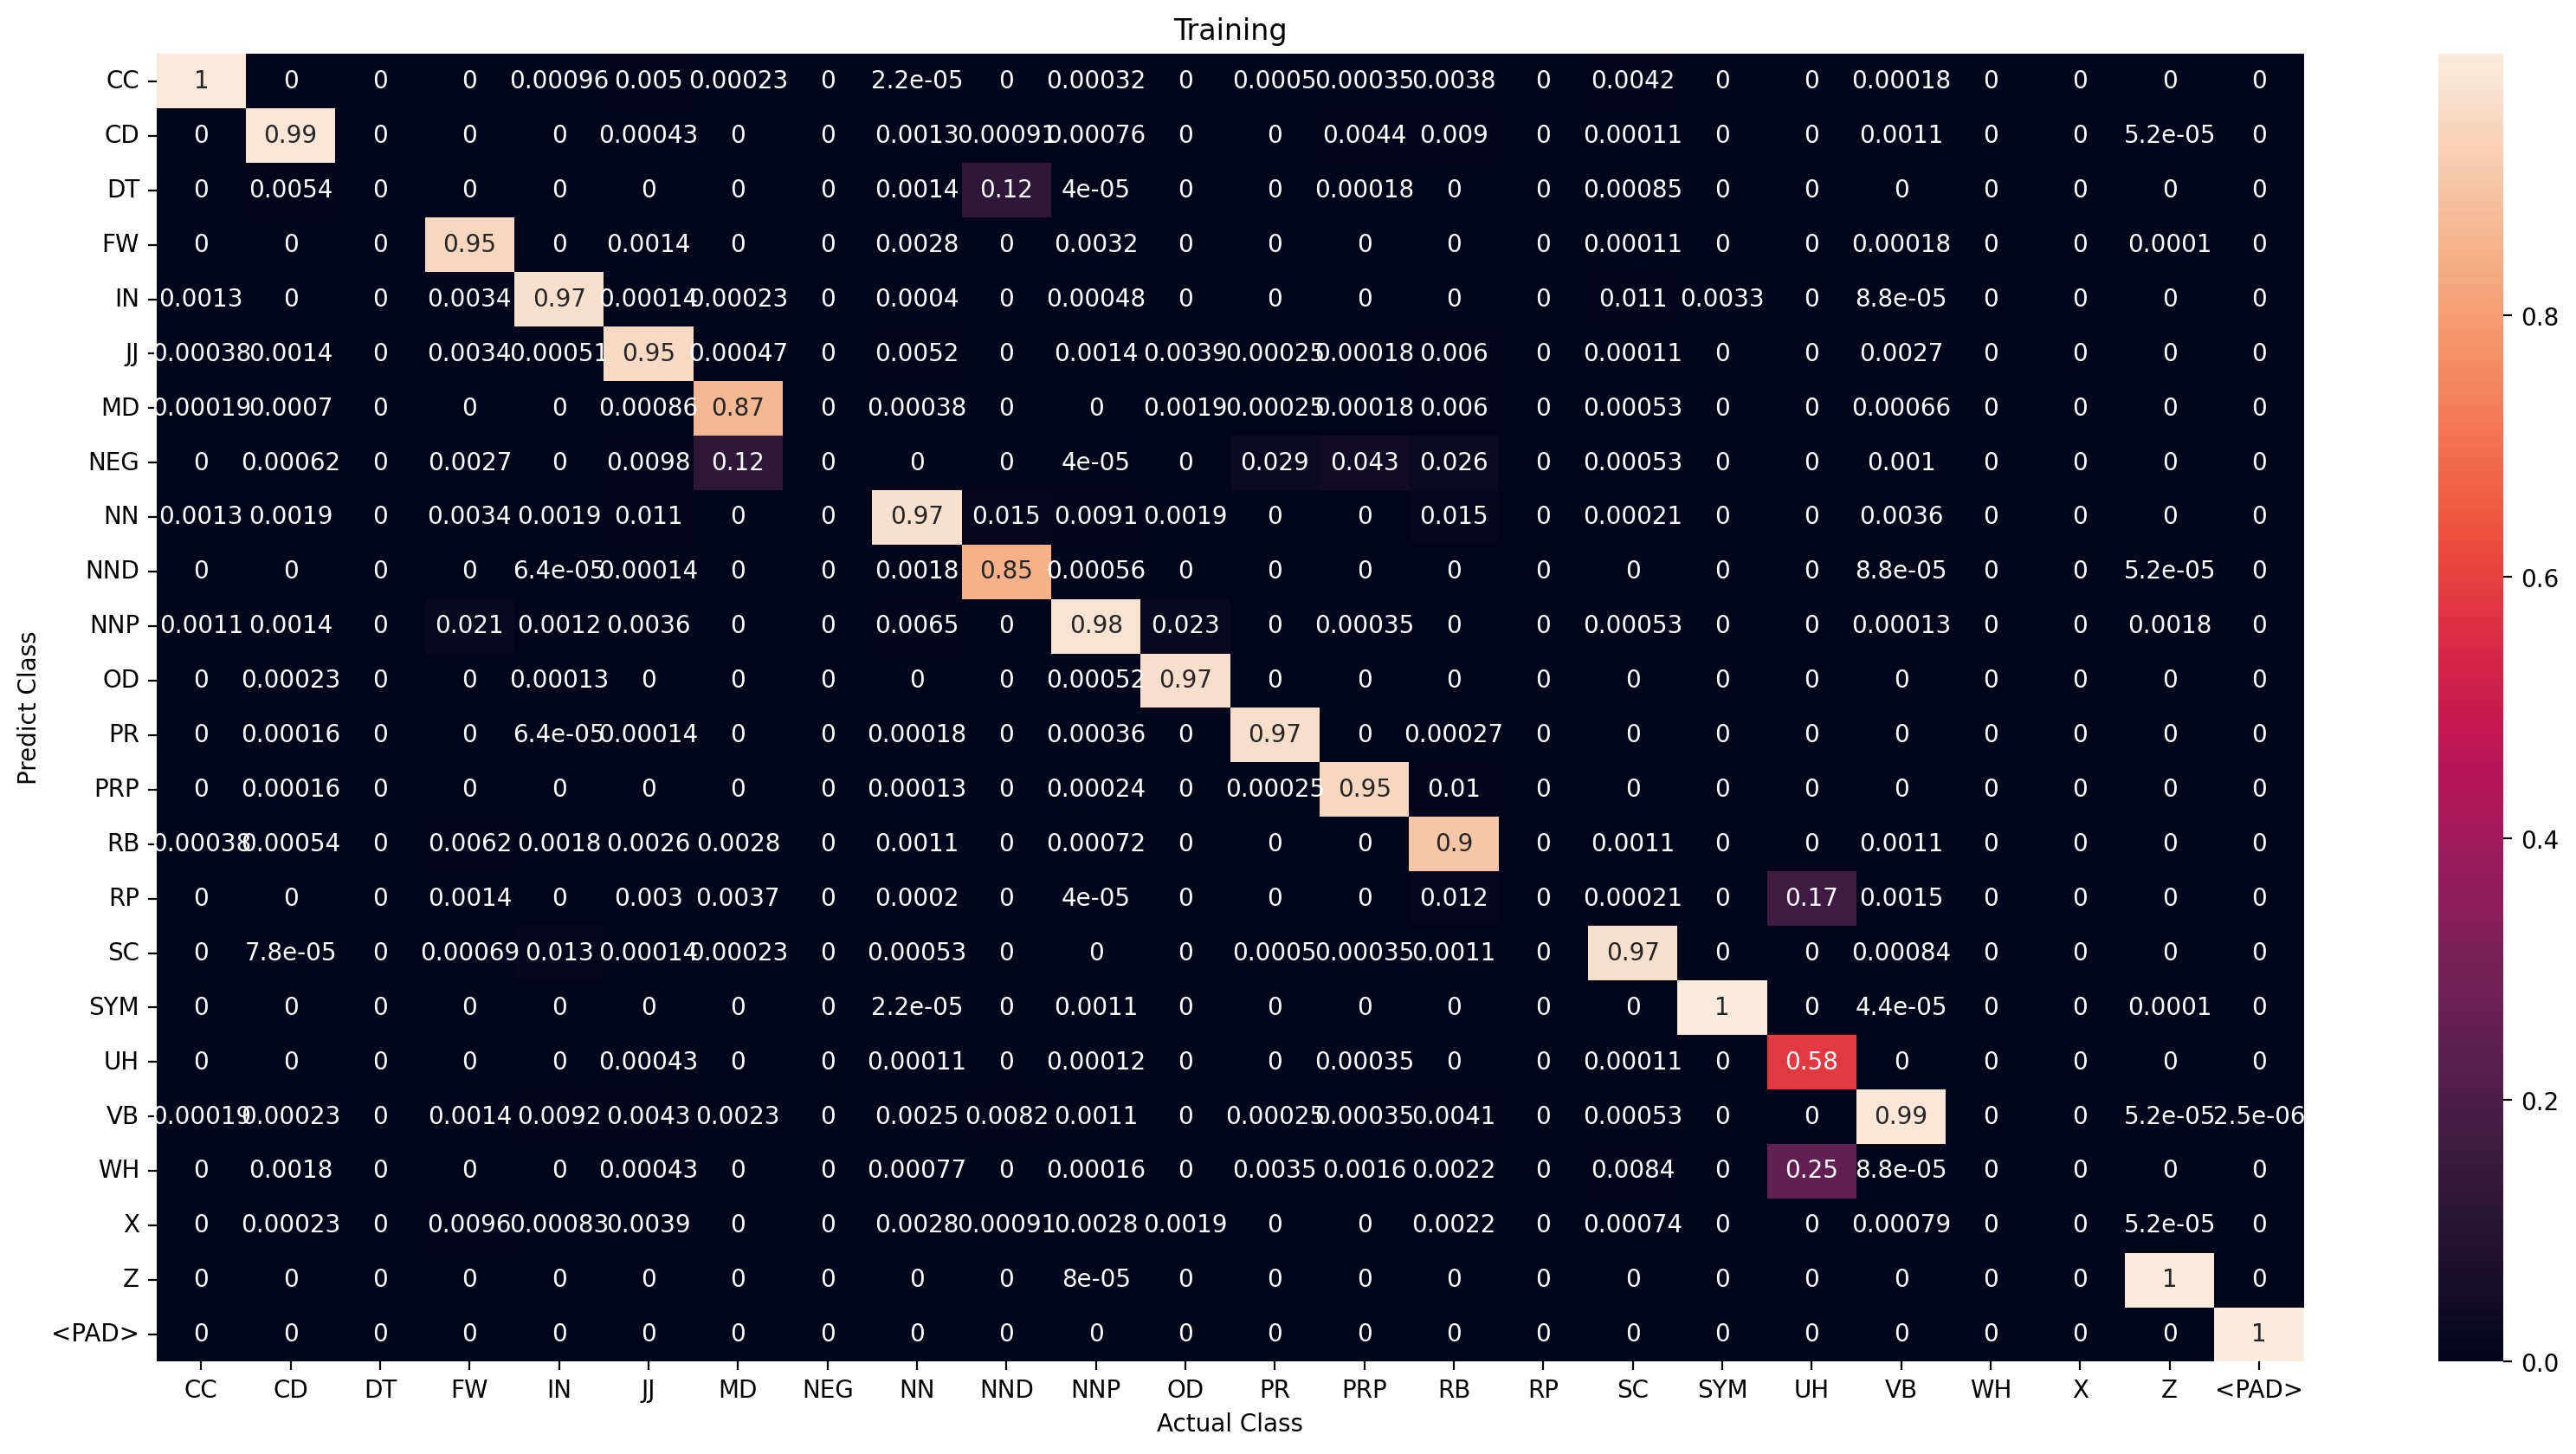

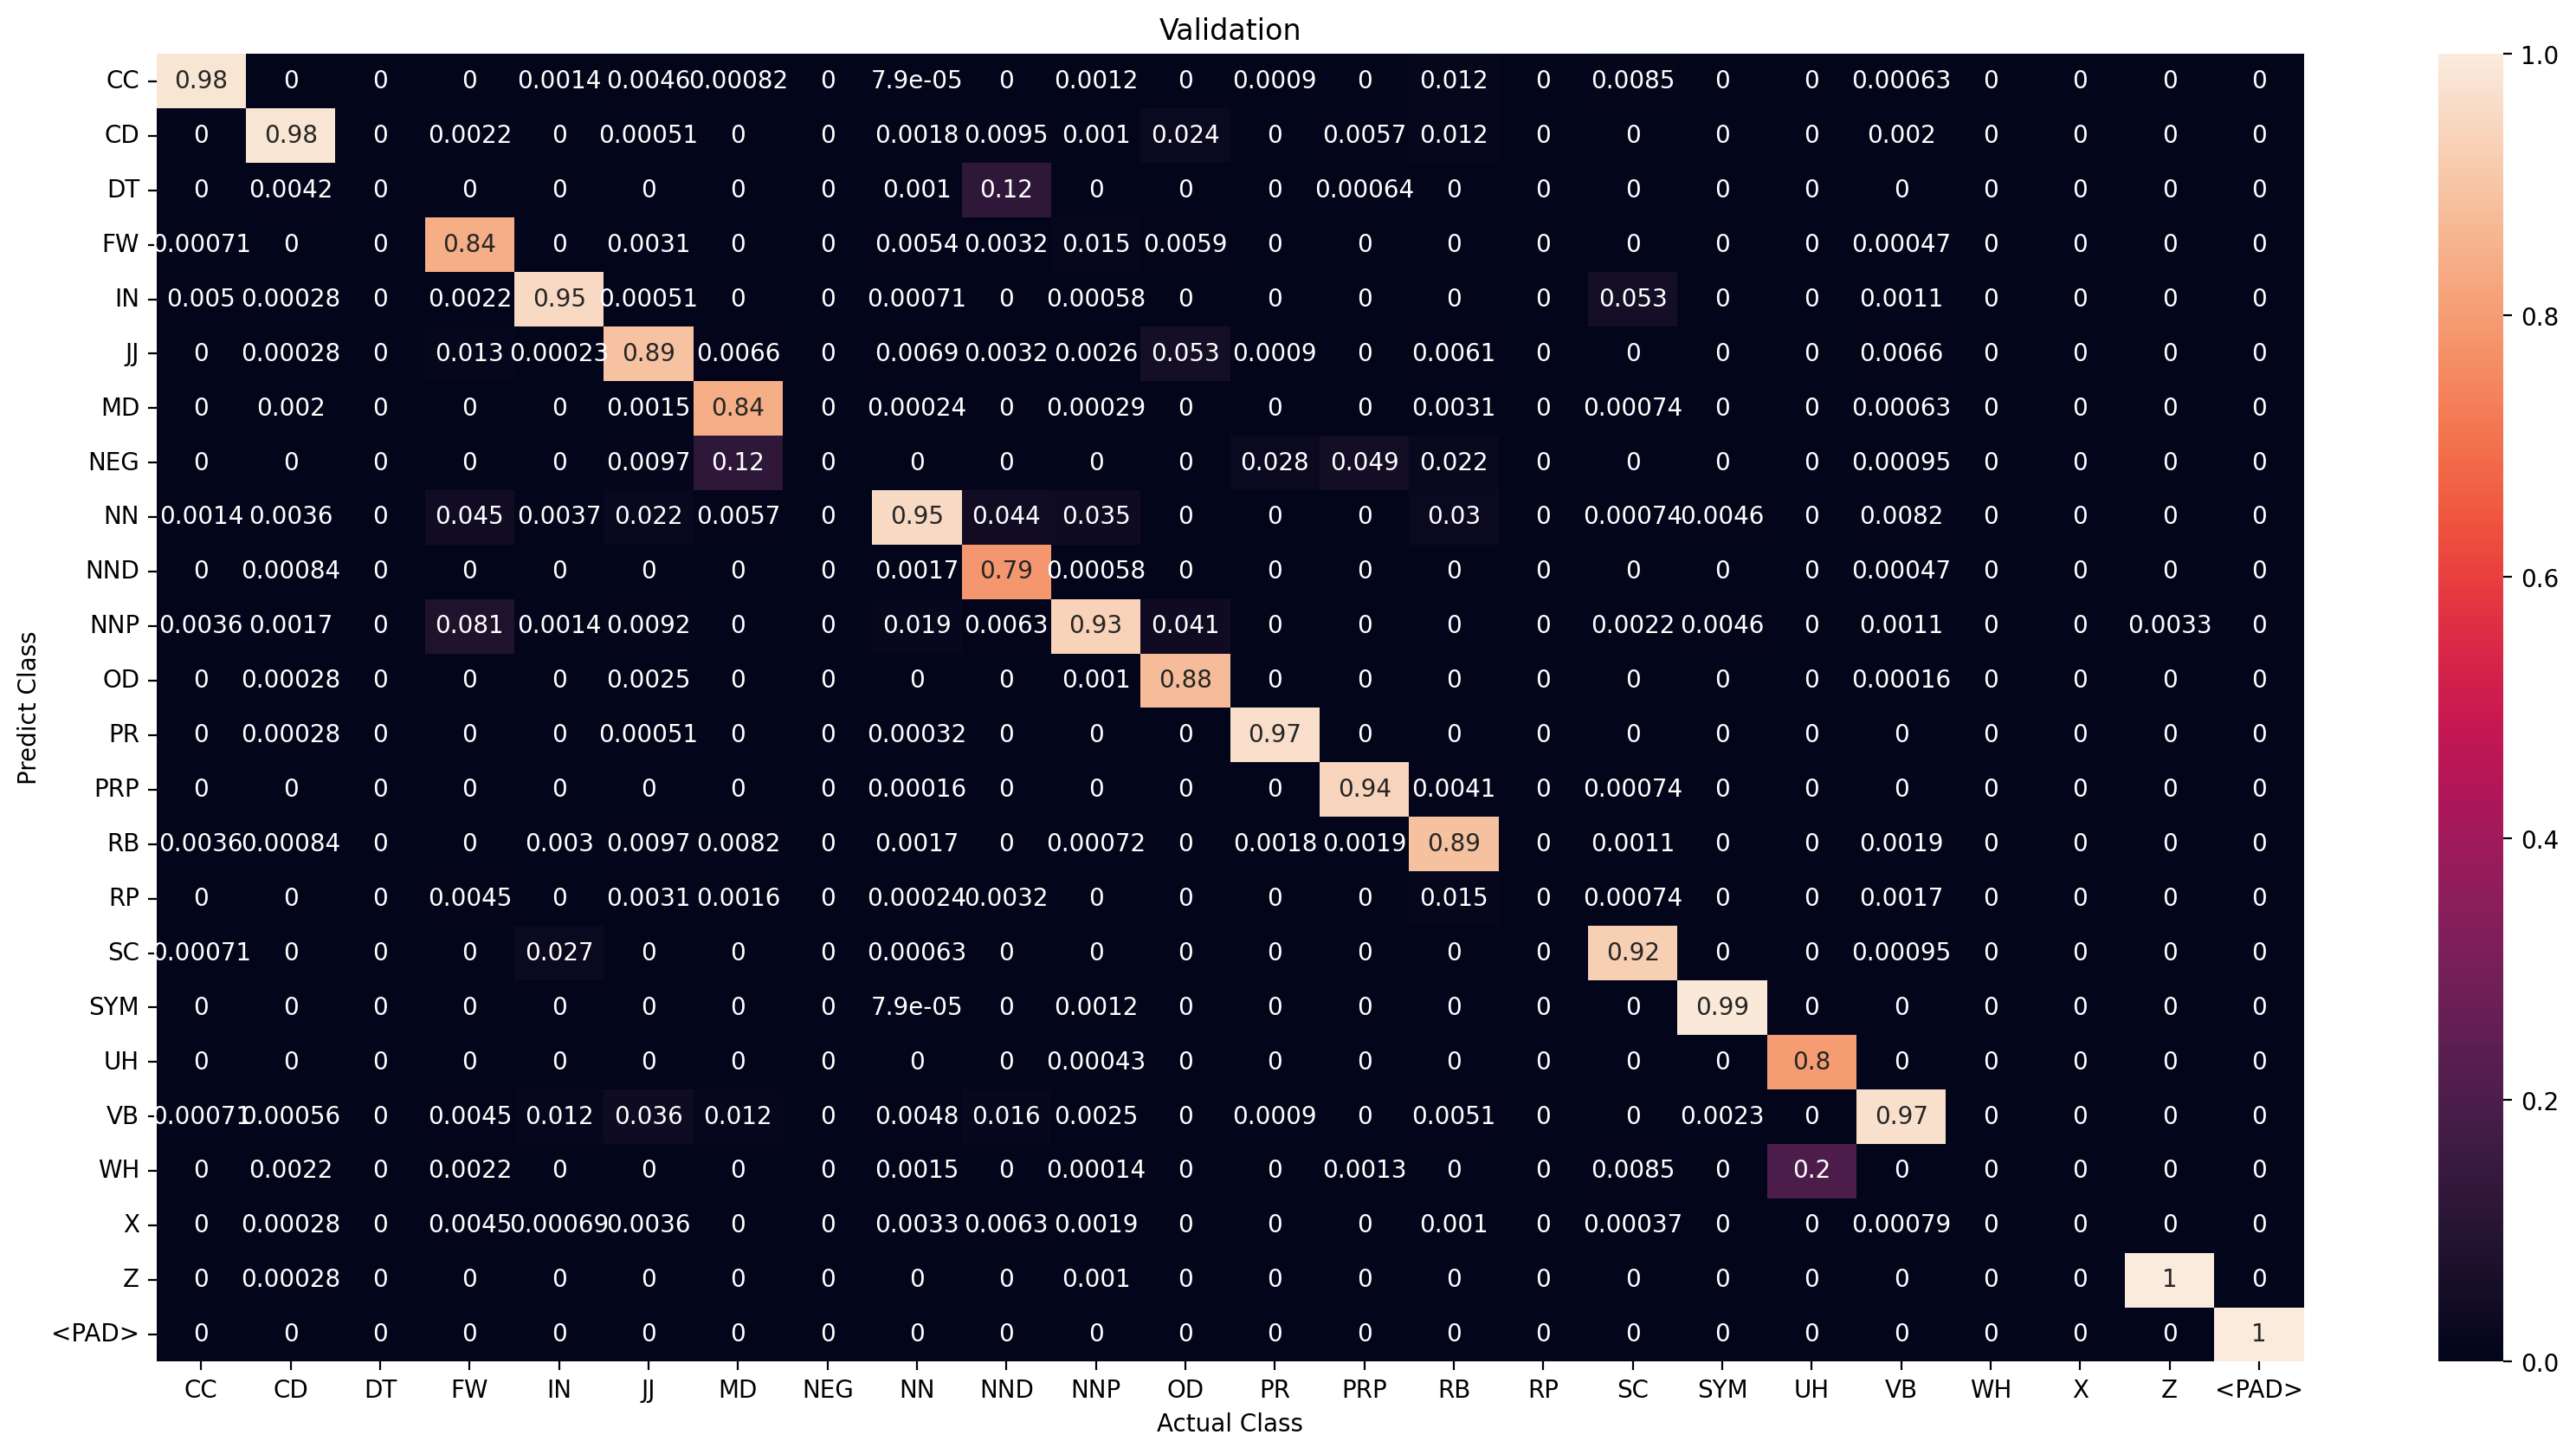

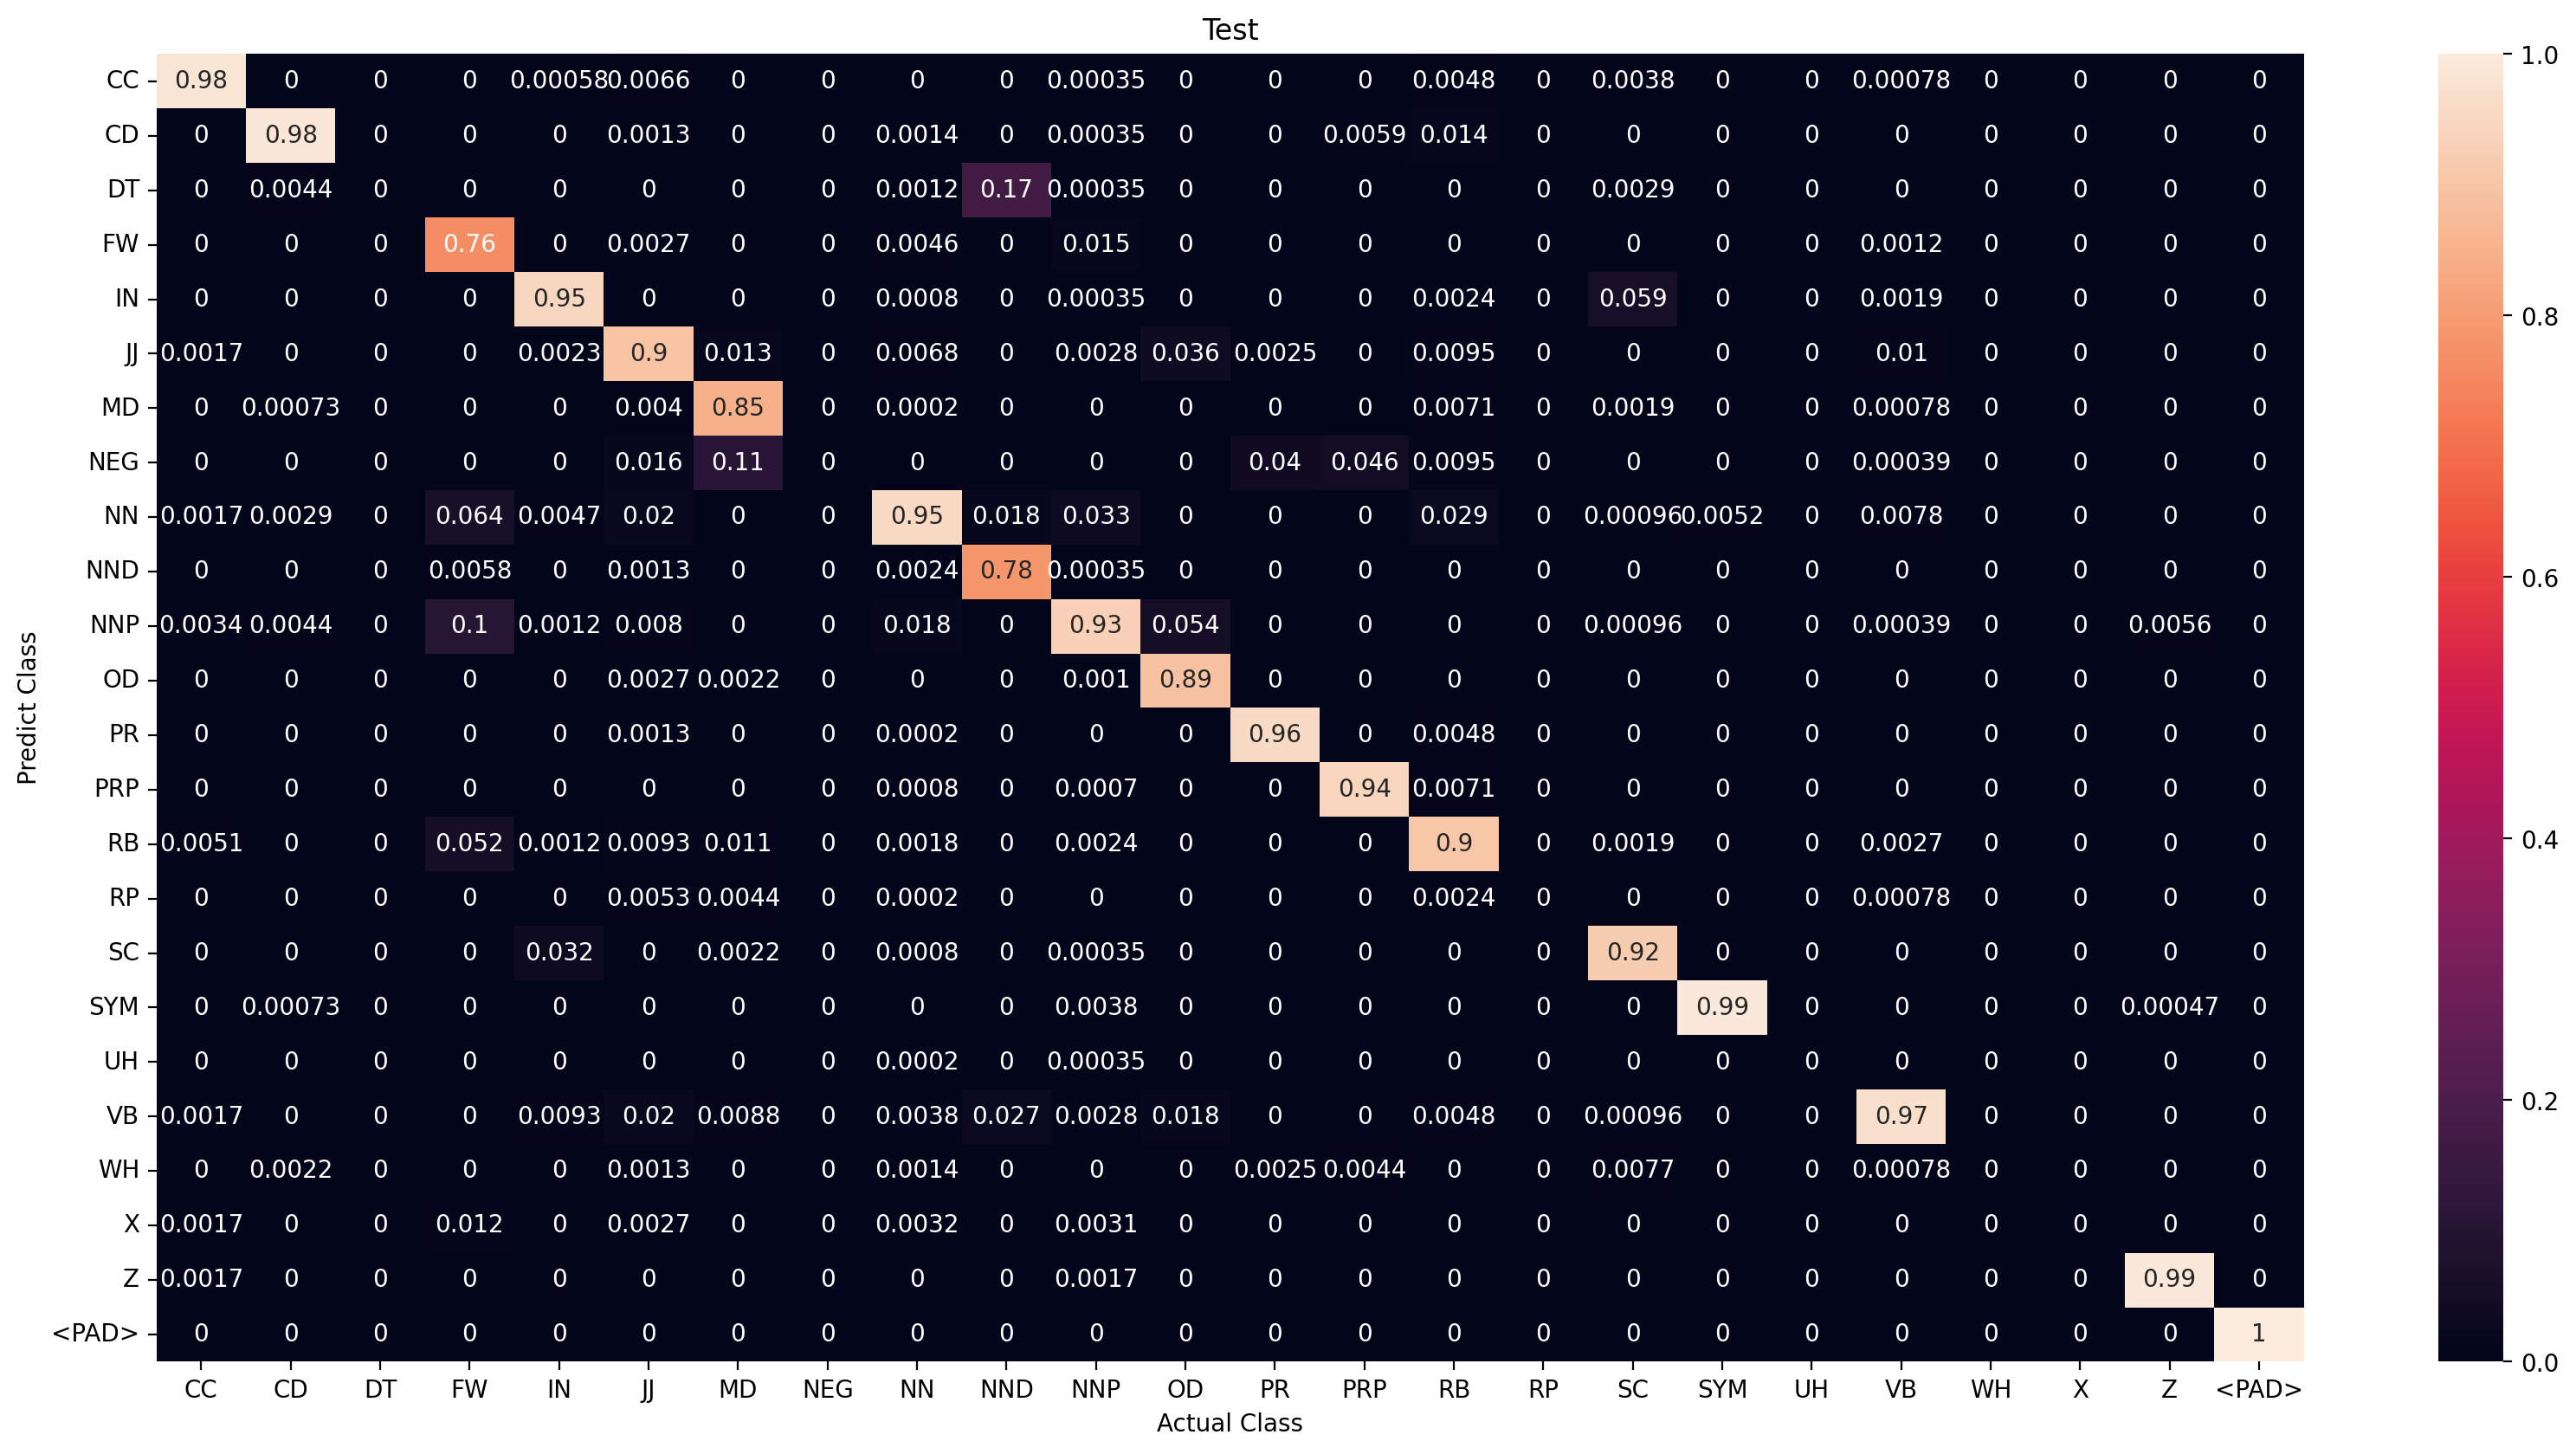

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5397   | CC    : 5275       | CC    : 122      |
| CD    : 12862  | CD    : 12694      | CD    : 168      |
| DT    : 278    | DT    : 0          | DT    : 278      |
| FW    : 1605   | FW    : 1381       | FW    : 224      |
| IN    : 15290  | IN    : 15132      | IN    : 158      |
| JJ    : 7025   | JJ    : 6629       | JJ    : 396      |
| MD    : 3798   | MD    : 3720       | MD    : 78       |
| NEG   : 1101   | NEG   : 0          | NEG   : 1101     |
| NN    : 44472  | NN    : 43942      | NN    : 530      |
| NND   : 1033   | NND   : 934        | NND   : 99       |
| NNP   : 25007  | NNP   : 24557      | NNP   : 450      |
| OD    : 519    | OD    : 501        | OD    : 18       |
| PR    : 3880   | PR    : 3858       | PR    : 22       |
| PRP   : 5449   | PRP   : 5397       | PRP   : 52       |
| RB    : 3502   | RB    : 3323       | RB    : 179      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8,  5, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11971
Correct prediction          : 11250
Wrong prediction            : 721
Percentage correct oov pred : 93.97711135243505

Validation
Number OOV token            : 3190
Correct prediction          : 2847
Wrong prediction            : 343
Percentage correct oov pred : 89.24764890282133

Test
Number OOV token            : 1401
Correct prediction          : 1264
Wrong prediction            : 137
Percentage correct oov pred : 90.22127052105638



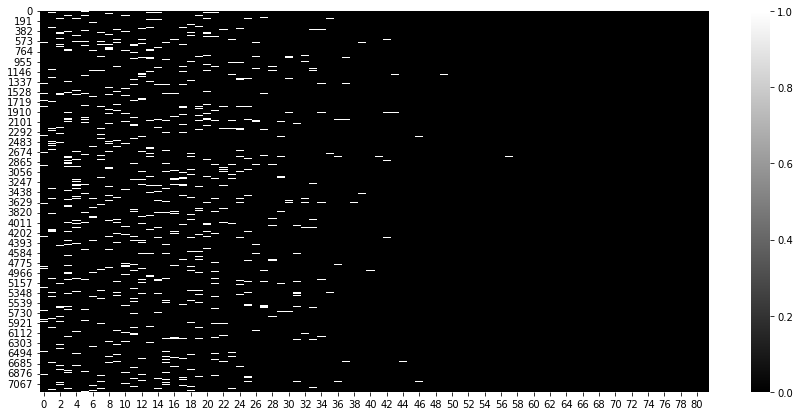

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

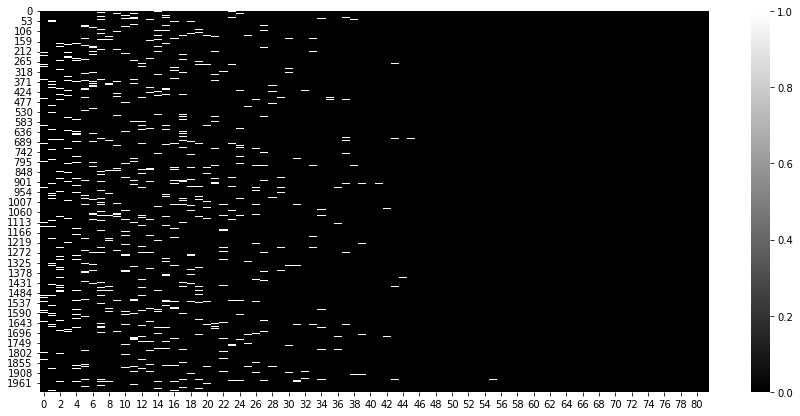

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

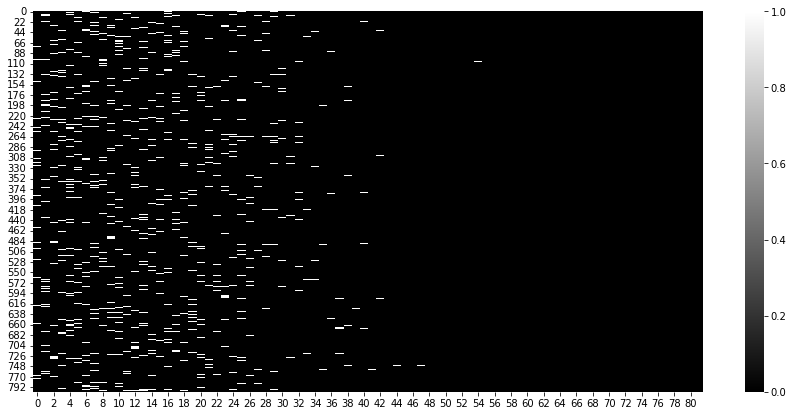

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);